Mounted at /content/drive
Saving outputs to: /content/drive/MyDrive/LJ_NVE_NVT_compare
step 0 | T=1.4574 | zeta=-9.662e-04
step 2000 | T=1.2204 | zeta=1.196e-01
step 4000 | T=1.4565 | zeta=6.684e-01
step 6000 | T=1.6179 | zeta=2.807e-01
step 8000 | T=1.5867 | zeta=-2.667e-01
step 10000 | T=1.4595 | zeta=-1.975e-02
step 12000 | T=1.4814 | zeta=1.640e-01
step 14000 | T=1.5641 | zeta=-2.890e-01
step 16000 | T=1.4850 | zeta=-3.874e-02
step 18000 | T=1.4583 | zeta=1.367e-01
NVT simulation complete.


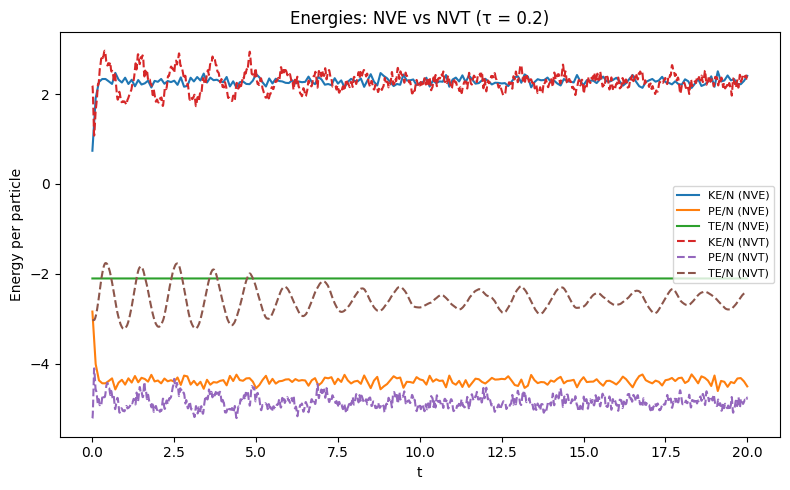

Saved: /content/drive/MyDrive/LJ_NVE_NVT_compare/energies_NVE_vs_NVT.png


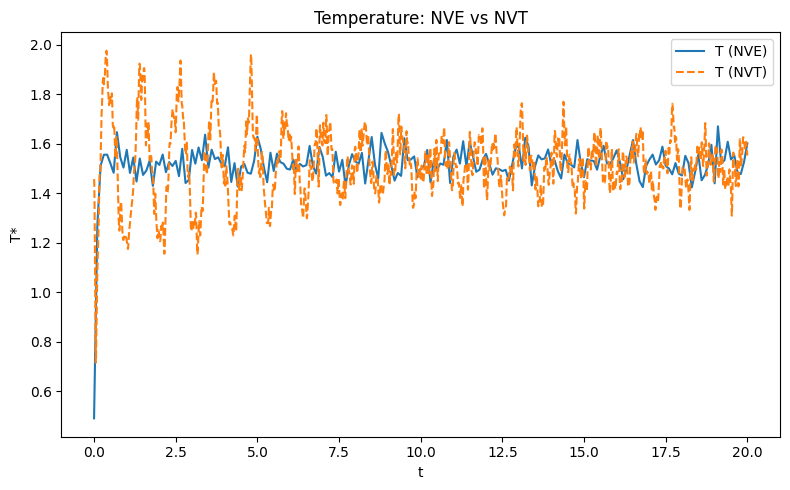

Saved: /content/drive/MyDrive/LJ_NVE_NVT_compare/temperature_NVE_vs_NVT.png


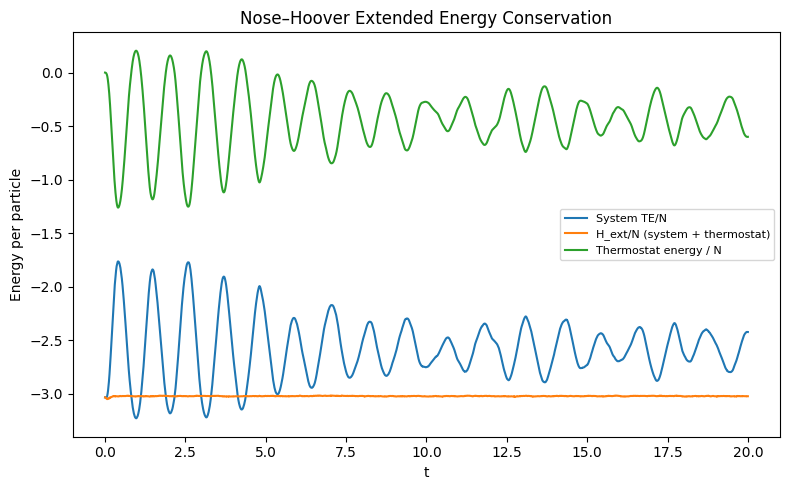

Saved: /content/drive/MyDrive/LJ_NVE_NVT_compare/extended_energy_NVT.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
NVE_ENERGY_FILE = "/content/drive/MyDrive/energy_rho0.844200_N216.out"

SAVE_DIR = "/content/drive/MyDrive/LJ_NVE_NVT_compare"
os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving outputs to:", SAVE_DIR)

N        = 216
rho      = 0.8442
T_target = 1.5228
total_time = 20.0
nsteps     = 20000
dt         = total_time / nsteps
rc         = 2.5
rc2        = rc**2

tau = 0.2
dof = 3*N - 3
Q   = dof * T_target * tau**2

np.random.seed(42)

nve = np.loadtxt(NVE_ENERGY_FILE)
step_nve   = nve[:,0]
ke_nve_pp  = nve[:,1]
pe_nve_pp  = nve[:,2]
tot_nve_pp = nve[:,3]

t_star = step_nve * dt
T_nve = (2.0/3.0) * ke_nve_pp

def init_positions_cubic(N, rho):
    V = N/rho
    L = V**(1/3)
    N_axis = int(np.ceil(N**(1/3)))
    a = L / N_axis
    pos = []
    for i in range(N_axis):
        for j in range(N_axis):
            for k in range(N_axis):
                if len(pos) < N:
                    pos.append([-L/2 + a/2 + i*a,
                                -L/2 + a/2 + j*a,
                                -L/2 + a/2 + k*a])
    return np.array(pos), L

def init_velocities_mb(N, T):
    v = np.random.normal(0, np.sqrt(T), size=(N,3))
    v -= v.mean(axis=0)
    return v

def apply_pbc(r, L):
    return (r + L/2) % L - L/2

def compute_forces_LJ(r, L):
    N = r.shape[0]
    F = np.zeros_like(r)
    PE = 0.0
    for i in range(N-1):
        rij = r[i] - r[i+1:]
        rij -= L*np.rint(rij/L)
        r2 = np.sum(rij**2,axis=1)
        m = r2 < rc2
        if not np.any(m):
            continue
        rij = rij[m]; r2 = r2[m]
        inv2 = 1.0/r2
        inv6 = inv2**3
        inv12 = inv6**2
        PE += np.sum(4*(inv12 - inv6))
        fij = ((48*inv12 - 24*inv6)*inv2)[:,None] * rij
        F[i] += np.sum(fij,axis=0)
        F[i+1:][m] -= fij
    return F, PE

def kinetic_energy(v):
    return 0.5*np.sum(v*v)

def temperature_inst(K, N):
    return (2/3)*K/N

r, L = init_positions_cubic(N, rho)
v = init_velocities_mb(N, T_target)
F, PE = compute_forces_LJ(r, L)
zeta = 0.0
eta  = 0.0

KE_list = []
PE_list = []
TE_list = []
T_list  = []
Hext_list = []
Eth_list  = []

for step in range(nsteps):

    K = kinetic_energy(v)
    T_inst = temperature_inst(K,N)

    KE_list.append(K)
    PE_list.append(PE)
    TE_list.append(K+PE)
    T_list.append(T_inst)

    zeta_old = zeta
    zeta += (dt/(2*Q))*(2*K - dof*T_target)
    v *= np.exp(-zeta*dt/2)
    v += 0.5*dt*F
    r += dt*v
    r = apply_pbc(r, L)
    F, PE = compute_forces_LJ(r, L)
    v += 0.5*dt*F
    v *= np.exp(-zeta*dt/2)

    K = kinetic_energy(v)
    zeta += (dt/(2*Q))*(2*K - dof*T_target)

    eta += 0.5*(zeta_old + zeta)*dt
    E_therm = 0.5*Q*zeta**2 + dof*T_target*eta
    H_ext   = K + PE + E_therm

    Eth_list.append(E_therm)
    Hext_list.append(H_ext)

t_nvt = np.arange(nsteps)*dt

KE_nvt_pp = np.array(KE_list)/N
PE_nvt_pp = np.array(PE_list)/N
TE_nvt_pp = np.array(TE_list)/N
T_nvt     = np.array(T_list)
Hext_pp   = np.array(Hext_list)/N
Eth_pp    = np.array(Eth_list)/N

plt.figure(figsize=(8,5))
plt.plot(t_star, ke_nve_pp,  label="KE/N (NVE)")
plt.plot(t_star, pe_nve_pp,  label="PE/N (NVE)")
plt.plot(t_star, tot_nve_pp, label="TE/N (NVE)")
plt.plot(t_nvt, KE_nvt_pp, '--', label="KE/N (NVT)")
plt.plot(t_nvt, PE_nvt_pp, '--', label="PE/N (NVT)")
plt.plot(t_nvt, TE_nvt_pp, '--', label="TE/N (NVT)")
plt.xlabel("t")
plt.ylabel("Energy per particle")
plt.legend(fontsize=8)
plt.title("Energies: NVE vs NVT (τ = 0.2)")
plt.tight_layout()
path1 = os.path.join(SAVE_DIR,"energies_NVE_vs_NVT.png")
plt.savefig(path1, dpi=300)
plt.show()
print("Saved:", path1)

plt.figure(figsize=(8,5))
plt.plot(t_star, T_nve, label="T (NVE)")
plt.plot(t_nvt, T_nvt, '--', label="T (NVT)")
plt.xlabel("t")
plt.ylabel("T*")
plt.legend()
plt.title("Temperature: NVE vs NVT")
plt.tight_layout()
path2 = os.path.join(SAVE_DIR,"temperature_NVE_vs_NVT.png")
plt.savefig(path2, dpi=300)
plt.show()
print("Saved:", path2)

plt.figure(figsize=(8,5))
plt.plot(t_nvt, TE_nvt_pp, label="System TE/N")
plt.plot(t_nvt, Hext_pp,   label="H_ext/N")
plt.plot(t_nvt, Eth_pp,    label="Thermostat energy / N")
plt.xlabel("t")
plt.ylabel("Energy per particle")
plt.legend(fontsize=8)
plt.title("Nose–Hoover Extended Energy Conservation")
plt.tight_layout()
path3 = os.path.join(SAVE_DIR,"extended_energy_NVT.png")
plt.savefig(path3, dpi=300)
plt.show()
print("Saved:", path3)
